## Building a Fermi Sky map with LEGOs
F. Acero, January 2018

Code to estimate the number of bricks to build a LEGO Fermi-LAT count map.
Also produces 3D Fermi sky maps.

In [1]:
%matplotlib inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from ipywidgets import interact, fixed

from astropy.io import fits
from astropy import table, wcs
from astropy.convolution import convolve,convolve_fft, Gaussian2DKernel
from astropy.coordinates import SkyCoord
from astropy import units as u

from scipy import interpolate

def myplot(im,stretch='sqrt',cmap='CMRmap_r'):
    
    plt.imshow(im, norm=simple_norm(im, stretch),cmap=cmap )
    plt.colorbar()
    plt.show()

def interp2d_astro(image,interpfactor, method='sum', **kwargs):
    """
    Interpolates 2D image.
    """
    if 'header' in kwargs: hdr = kwargs['header']

    x = np.arange(0,image.shape[1] , 1)
    y = np.arange(0,image.shape[0] , 1)
    f = interpolate.interp2d(x, y, image, kind='linear')

    xnew = np.arange(0,image.shape[1] , 1./interpfactor)
    ynew = np.arange(0,image.shape[0] , 1./interpfactor)

    if method == 'mean':
        print('WARNING MEAN' )
        image2 = f(xnew,ynew) #  interpolation with a mean
    if method == 'sum' :
        print( 'WARNING SUM' )
        image2 = f(xnew,ynew) / (interpfactor**2) # to preserve counts sum

    if 'header' in kwargs:
        #Modifying header to account for interpolation
        try:
            hdr['CDELT1'] =  hdr['CDELT1']/interpfactor
            hdr['CDELT2'] =  hdr['CDELT2']/interpfactor
        except:
            CDELT = hdr['CD1_1']
            hdr['CD1_1'] =  hdr['CD1_1']/interpfactor
            hdr['CD2_2'] =  hdr['CD2_2']/interpfactor

        hdr['CRPIX1'] =  hdr['CRPIX1']*interpfactor
        hdr['CRPIX2'] =  hdr['CRPIX2']*interpfactor

    if 'header' in kwargs: return image2, hdr
    else: return image2


## Importing Fermi sky map

Import Fermi-LAT fits file from 6yrs sky map (Pass8, PSF3 cuts, E > 1 GeV).


Total number of photons: 6552.77236451
# of pixels < 5: 2508
# of pixels > 5 < 10: 57
# of pixels > 10: 0
# of pixels > 50: 0


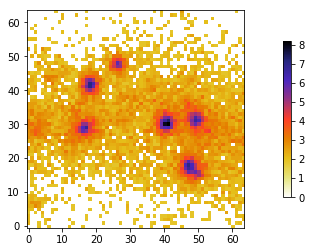

In [7]:
infile='cmap_ait_72m_gt1000_P8_psf3_gal_0p1.FTZ'

im=fits.getdata(infile) 
header=fits.getheader(infile)
w = wcs.WCS(header).celestial 

#cropping image on pixels coordinates
xc,yc= 2527, 896 # center on Carina
xw,yw=32,32      # half width

#xc,yc= 1035, 907 # center on Cygnus
#xw,yw=32,32      # half width

#
#xc,yc= 1870, 1078 # Rho Ophicius ? (Crab pince ?) 
#xw,yw=32,32      # half width

#xc,yc= 2275, 898 # XX ???
#xw,yw=32,32      # half width

#xc,yc= 1745, 900 # GC ???
#xw,yw=450,100      # half width 90°x30°

#xc,yc= 1340, 900 # GC ???
#xw,yw=600,100      # half width 90°x30°


im = im[ yc-yw:yc+yw, xc-xw:xc+xw]

#im=interp2d_astro(im,.5,method='mean')

im[im<5]=0
#im[im>250]=250
#im=im/4
#im[im ==0]=0.1
im=im**(0.4)
#im=np.log10(im)

#im=np.rint(im) # round to nearest integer

#im=im-3

print('Total number of photons:',im.sum())

print('# of pixels < 5:', ((im <5) * (im>0)).sum())
print('# of pixels > 5 < 10:', ((im >=5) * (im<10)).sum())
print('# of pixels > 10:', (im >10).sum())
print('# of pixels > 50:', (im >50).sum())


fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1) #, projection=w)
p1=ax.imshow(im, norm=simple_norm(im, 'linear'),cmap='CMRmap_r'  )
plt.colorbar(p1,fraction=0.01,ax=ax)
plt.show()

#step=50
#for i in np.arange(0,2*xw/step):
#    print(i*step)
#    x1,x2=i*step,(i+1)*step
#    imc=im[27:77,x1:x2]
#    print("# photons=",imc.sum())
#    myplot(imc,stretch='linear')

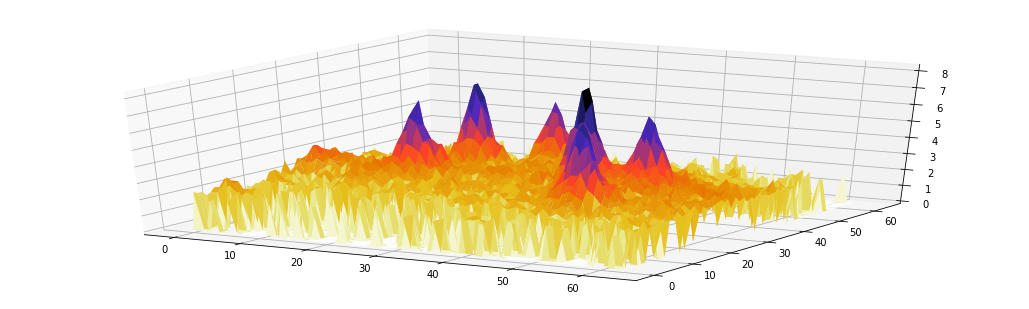

TypeError: slice indices must be integers or None or have an __index__ method

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

x = np.arange(im.shape[1])
y = np.arange(im.shape[0])

xs, ys = np.meshgrid(x, y)

zs = im
fig = plt.figure(figsize=(14,4))
ax = Axes3D(fig)
ax.plot_surface(xs, ys, zs, rstride=1, cstride=1, cmap='CMRmap_r')
plt.show()


xlims = np.arange(im.shape[0]+1)
ylims = np.arange(im.shape[1]+1)

X,Y,Z=prepareLegoData(xlims, ylims, im)
ax = Axes3D(plt.figure())
ax.plot_surface(X, Y, Z, cmap='CMRmap_R')

plt.show()



In [9]:
## From ScienceTools

"""Lego.py
   Methods to create a "lego" style plot using the surface
   plot methods from matplotlib's Axes3D class
"""

import numpy

def makeVectorRedundant(xs, repeat):
    t = numpy.zeros(repeat * xs.shape[0])
    for i in range(repeat):
        t[i::repeat] = xs
    return t

def printVals(X,Y,Z):
    print(X,"\n")
    print(Y,"\n")
    print(Z,"\n")


def prepareLegoData(xlims, ylims, zvals):
    """Prepare 3D histogram data to be used with matplotlib's Axes3D/Axes3DI.

    usage example:

    >>> nx, ny = 3, 5
    >>> X, Y, Z = prepareLegoData(numpy.arange(nx), numpy.arange(ny),
    ... numpy.random.rand(nx, ny))
    >>> fig = pylab.figure()
    >>> ax = matplotlib.axes3d.Axes3DI(fig)
    >>> ax.plot_surface(X, Y, Z, rstride=2, cstride=2)
    >>> pylab.show()

    @param xlims: N+1 array with the bin limits in x direction
    @param ylims: M+1 array with the bin limits in y direction
    @param zvals: a 2D array with shape (N, M) with the bin entries,
        example::
        --> y-index (axis 1)
        |       z_0_0  z_0_1  ...
        |       z_1_0  z_1_1  ...
        V        ...
        x-index (axis 0)
    @returns: a tuple containing X, Y, Z 2D-arrays for Axes3D plotting methods
    """
    xlims = numpy.array(xlims)
    ylims = numpy.array(ylims)
    zvals = numpy.array(zvals)

    assert xlims.shape[0] - 1 == zvals.shape[0]
    assert ylims.shape[0] - 1 == zvals.shape[1]

    # use a higher redundancy for surface_plot
    # must be a multiple of 2!
    repeat = 4

    X, Y = numpy.meshgrid(makeVectorRedundant(xlims, repeat),
                          makeVectorRedundant(ylims, repeat))
    Z = numpy.zeros(X.shape)

    # enumerate the columns of th zvals
    for yi, zvec in enumerate(zvals):
        t = makeVectorRedundant(zvec, repeat)
        for off in range(1, repeat+1):
            Z[repeat/2:-repeat/2, repeat*yi + off] = t
#    printVals(X,Y,Z)
    return X, Y, Z